In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [2]:
bolsa = pd.read_csv('data.csv')

In [3]:
len(bolsa)

7275

In [4]:
bolsa.columns=['Year', 'Month', 'Day', 'Precio_Bolsa_Nacional', 'CEE','CERE', 'Precio_Escasez', 'Precio_Escasez_Activación']

In [5]:
bolsa['date']=pd.to_datetime((bolsa.Year*10000+bolsa.Month*100+bolsa.Day).apply(str),format='%Y%m%d')

In [6]:
df= bolsa.copy()
#Get the year values of indexes for which Year is lower than 2010
indexDates = df[df['Year']>2018].index

#Delete the
df.drop(indexDates, inplace=True)
df.head()

,Year,Month,Day,Precio_Bolsa_Nacional,CEE,CERE,Precio_Escasez,Precio_Escasez_Activación,date
0,2000,1,1,32.8681,21.55,22.8348,NaN,NaN,2000-01-01
1,2000,1,2,33.0348,21.55,22.8348,NaN,NaN,2000-01-02
2,2000,1,3,37.2723,21.55,22.8348,NaN,NaN,2000-01-03
3,2000,1,4,41.6890,21.55,22.8348,NaN,NaN,2000-01-04
4,2000,1,5,40.8931,21.55,22.8348,NaN,NaN,2000-01-05


In [7]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

In [8]:
len(df)

6940

In [9]:
uni_data = df['Precio_Bolsa_Nacional']
uni_data.index = df['date']
uni_data.head()

date
2000-01-01    32.8681
2000-01-02    33.0348
2000-01-03    37.2723
2000-01-04    41.6890
2000-01-05    40.8931
Name: Precio_Bolsa_Nacional, dtype: float64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000015A733CA9E8>],
      dtype=object)

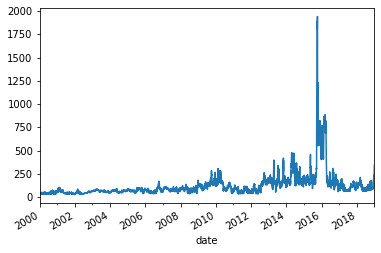

In [10]:
uni_data.plot(subplots=True)

In [11]:
uni_data = uni_data.values

El numero de datos entre el 2000 y el 2018 es 6940
<br>
TRAIN_SPLIT = 300000

In [17]:
percent_train= 0.8*len(uni_data)
TRAIN_SPLIT=int(percent_train)
TRAIN_SPLIT

5552

In [18]:
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()

In [19]:
uni_data = (uni_data-uni_train_mean)/uni_train_std

In [20]:
uni_data

date
2000-01-01   -1.027146
2000-01-02   -1.024530
2000-01-03   -0.958034
2000-01-04   -0.888725
2000-01-05   -0.901215
                ...   
2018-12-27    2.679206
2018-12-28    3.099614
2018-12-29    3.181429
2018-12-30    3.561147
2018-12-31    3.864457
Name: Precio_Bolsa_Nacional, Length: 6940, dtype: float64

In [21]:
univariate_past_history = 20
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

KeyError: range(0, 20)

In [16]:
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target temperature to predict')
print (y_train_uni[0])

Single window of past history


NameError: name 'x_train_uni' is not defined

In [15]:
def create_time_steps(length):
  time_steps = []
  for i in range(-length, 0, 1):
    time_steps.append(i)
  return time_steps

In [16]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

<module 'matplotlib.pyplot' from 'C:\\Users\\Maria.Montoya\\AppData\\Local\\Continuum\\anaconda3\\envs\\DS4A_test\\lib\\site-packages\\matplotlib\\pyplot.py'>

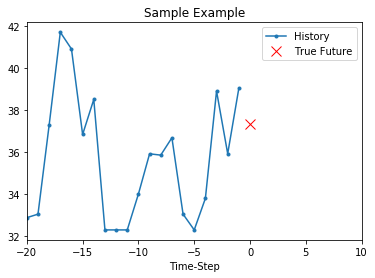

In [17]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

### Baseline

In [18]:
def baseline(history):
  return np.mean(history)

<module 'matplotlib.pyplot' from 'C:\\Users\\Maria.Montoya\\AppData\\Local\\Continuum\\anaconda3\\envs\\DS4A_test\\lib\\site-packages\\matplotlib\\pyplot.py'>

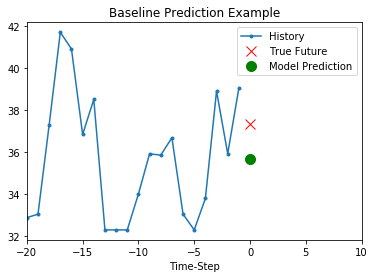

In [19]:
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,
           'Baseline Prediction Example')

### Recurrent neural network

In [20]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [21]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

In [22]:
for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

(256, 1)


In [23]:
EVALUATION_INTERVAL = 200
EPOCHS = 10

simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 4s 22ms/step - loss: 97.5822 - val_loss: 222.8333
Epoch 2/10
200/200 [==============================] - 2s 8ms/step - loss: 94.8379 - val_loss: 221.4150
Epoch 3/10
200/200 [==============================] - 2s 8ms/step - loss: 93.6341 - val_loss: 219.6751
Epoch 4/10
200/200 [==============================] - 2s 8ms/step - loss: 91.8008 - val_loss: 218.1984
Epoch 5/10
200/200 [==============================] - 2s 8ms/step - loss: 90.2967 - val_loss: 216.8659
Epoch 6/10
200/200 [==============================] - 1s 7ms/step - loss: 89.0135 - val_loss: 215.5812
Epoch 7/10
200/200 [==============================] - 2s 8ms/step - loss: 87.8089 - val_loss: 214.3218
Epoch 8/10
200/200 [==============================] - 2s 8ms/step - loss: 86.6087 - val_loss: 213.0782
Epoch 9/10
200/200 [==============================] - 2s 8ms/step - loss: 85.1706 - val_loss: 211.8451
Epoch 10/10
200/200 [========

### Predict using the simple LSTM model

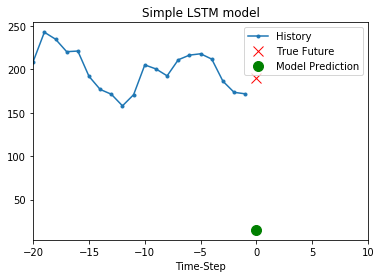

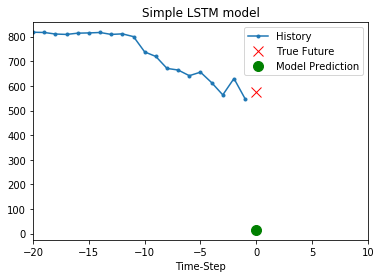

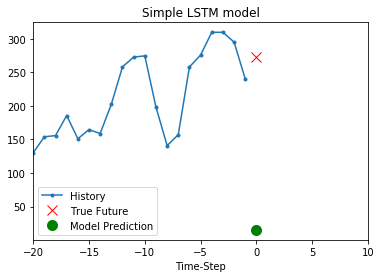

In [25]:
for x, y in val_univariate.take(3):
  plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
  plot.show()

### Part 2: Forecast a multivariate time series

In [26]:
features_considered = ['Precio_Bolsa_Nacional', 'CEE', 'CERE']

In [27]:
features = df[features_considered]
features.index = df['date']
features.head()

,Precio_Bolsa_Nacional,CEE,CERE
date,,,
2000-01-01,32.8681,21.55,22.8348
2000-01-02,33.0348,21.55,22.8348
2000-01-03,37.2723,21.55,22.8348
2000-01-04,41.6890,21.55,22.8348
2000-01-05,40.8931,21.55,22.8348


array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000015A78D69E48>,
      dtype=object)

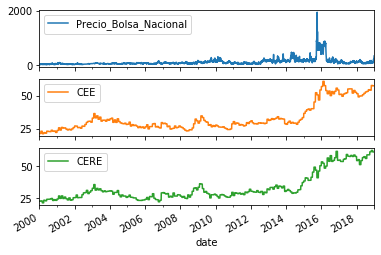

In [28]:
features.plot(subplots=True)

In [29]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

In [30]:
dataset = (dataset-data_mean)/data_std

In [ ]:
dictvar = dict()
for feat in features.columns:
    mean = features[feat].mean()
    std = features[feat].std()
    columna = (features[feat]-mean)/std
    dictvar[feat] = columna
datasetI = pd.DataFrame.from_dict(dictvar)

### Single step model

In [31]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [32]:
past_history = 720
future_target = 72
STEP = 6

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

In [33]:
print ('Single window of past history : {}'.format(x_train_single[0].shape))

Single window of past history : (120, 3)


In [34]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [35]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32,
                                           input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

In [36]:
for x, y in val_data_single.take(1):
  print(single_step_model.predict(x).shape)

(256, 1)


In [37]:
single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 19s 95ms/step - loss: nan - val_loss: nan
Epoch 2/10
200/200 [==============================] - 18s 91ms/step - loss: nan - val_loss: nan
Epoch 3/10
200/200 [==============================] - 18s 91ms/step - loss: nan - val_loss: nan
Epoch 4/10
200/200 [==============================] - 18s 92ms/step - loss: nan - val_loss: nan
Epoch 5/10
200/200 [==============================] - 19s 94ms/step - loss: nan - val_loss: nan
Epoch 6/10
200/200 [==============================] - 19s 94ms/step - loss: nan - val_loss: nan
Epoch 7/10
200/200 [==============================] - 19s 94ms/step - loss: nan - val_loss: nan
Epoch 8/10
200/200 [==============================] - 19s 95ms/step - loss: nan - val_loss: nan
Epoch 9/10
200/200 [==============================] - 19s 96ms/step - loss: nan - val_loss: nan
Epoch 10/10
200/200 [==============================] - 20s 99ms/step - loss: nan - val_loss: 

In [38]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

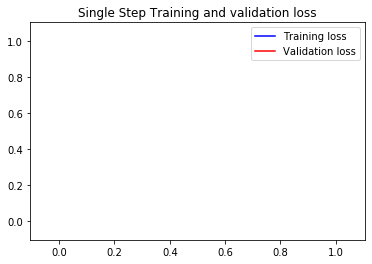

In [96]:
plot_train_history(single_step_history,
                   'Single Step Training and validation loss')